# _desafío 2_ **Sebastián Acevedo Espinoza**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

## **Pregunta 1**

## a)

### I)

In [84]:
# Cargamos los archivos
df_cleveland = pd.read_csv("processed.cleveland.csv")
df_hungarian = pd.read_csv("processed.hungarian.csv")
df_switzerland = pd.read_csv("processed.switzerland.csv")

# Unimos los DataFrames con concatenación
# Los DataFrames tienen la misma estructura de columnas
df = pd.concat([df_cleveland, df_hungarian, df_switzerland], ignore_index=True)

# Transformamos la variable objetivo 'num'
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

# Contamos los valores ausentes
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100 # Porcentaje de valores ausentes por columna

print("Valores ausentes por atributo (%):")
print(missing_percent)

# Eliminamos las columnas con más de 25% de valores ausentes
columns_to_drop = missing_percent[missing_percent > 25].index
df = df.drop(columns=columns_to_drop)

print("\nColumnas eliminadas por más de 25% de valores ausentes:")
print(list(columns_to_drop))

# Mostramos el resumen del DataFrame procesado
print("\nForma final del DataFrame:", df.shape)
df


Valores ausentes por atributo (%):
age          0.0
sex          0.0
cp           0.0
threstbps    0.0
chol         0.0
fbs          0.0
restecg      0.0
thalach      0.0
exang        0.0
oldpeak      0.0
slope        0.0
ca           0.0
thal         0.0
num          0.0
dtype: float64

Columnas eliminadas por más de 25% de valores ausentes:
[]

Forma final del DataFrame: (720, 14)


,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,70.0,1.0,4.0,115,0,0,1,92,1,0,2,?,7,1
716,70.0,1.0,4.0,140,0,1,0,157,1,2,2,?,7,1
717,72.0,1.0,3.0,160,0,?,2,114,0,1.6,2,2,?,0
718,73.0,0.0,3.0,160,0,0,1,121,0,0,1,?,3,1


### II)

In [85]:
#Eliminamos las filas con valores '?' en columnas específicas
cols_con_question = ["thal", "ca", "slope"]  # por ejemplo
for col in cols_con_question:
    df = df[df[col] != "?"]


In [86]:
# Imputación de valores nulos
# Imputamos valores nulos en columnas numéricas según la clase 'num'
for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].isnull().mean() <= 0.25:
        # Calcular promedio por clase
        mean_0 = df[df['num'] == 0][col].mean()
        mean_1 = df[df['num'] == 1][col].mean()
        
        # Imputar según la clase
        df.loc[(df['num'] == 0) & (df[col].isnull()), col] = round(mean_0)
        df.loc[(df['num'] == 1) & (df[col].isnull()), col] = round(mean_1)


# Verificación final
print("¿Quedan valores nulos?", df.isnull().sum().sum())
df

¿Quedan valores nulos? 0


,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [87]:
# Lista de variables categóricas
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Imputamos los valores faltantes en columnas categóricas si existen
for col in categorical_cols:
    if df[col].isnull().sum() > 0 and df[col].isnull().mean() <= 0.25:
        # Promedio por clase, redondeado
        mean_0 = round(df[df['num'] == 0][col].mean())
        mean_1 = round(df[df['num'] == 1][col].mean())

        # Imputación según clase
        df.loc[(df['num'] == 0) & (df[col].isnull()), col] = mean_0
        df.loc[(df['num'] == 1) & (df[col].isnull()), col] = mean_1


# Verificamos que ya no haya valores faltantes
print("¿Quedan valores nulos?", df.isnull().sum().sum())


¿Quedan valores nulos? 0


## b)

In [88]:
# Copiamos de trabajo del DataFrame original
df_dummies = df.copy()

# Variables con tres o más categorías (según descripción)
# cp (1-4), restecg (0-2), slope (1-3), thal (3,6,7)
categorical_multi = ['cp', 'restecg', 'slope', 'thal']

# Creamos las variables dummies (drop_first=True para evitar multicolinealidad)
df_dummies = pd.get_dummies(df_dummies, columns=categorical_multi, drop_first=True)

# Mostramos las nuevas columnas generadas y forma del DataFrame
df_dummies

,age,sex,threstbps,chol,fbs,thalach,exang,oldpeak,ca,num,...,cp_4.0,restecg_1.0,restecg_2.0,restecg_0,slope_2.0,slope_3.0,slope_2,thal_6.0,thal_7,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0,...,False,False,True,False,False,True,False,True,False,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,1,...,True,False,True,False,True,False,False,False,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1,...,True,False,True,False,True,False,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,False,False,False,False,False,True,False,False,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,0.0,1,...,False,False,False,False,True,False,False,False,False,True
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,2.0,1,...,True,False,False,False,True,False,False,False,False,True
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,1,...,True,False,False,False,True,False,False,False,False,True
301,57.0,0.0,130.0,236.0,0.0,174.0,0.0,0.0,1.0,1,...,False,False,True,False,True,False,False,False,False,False


## c)

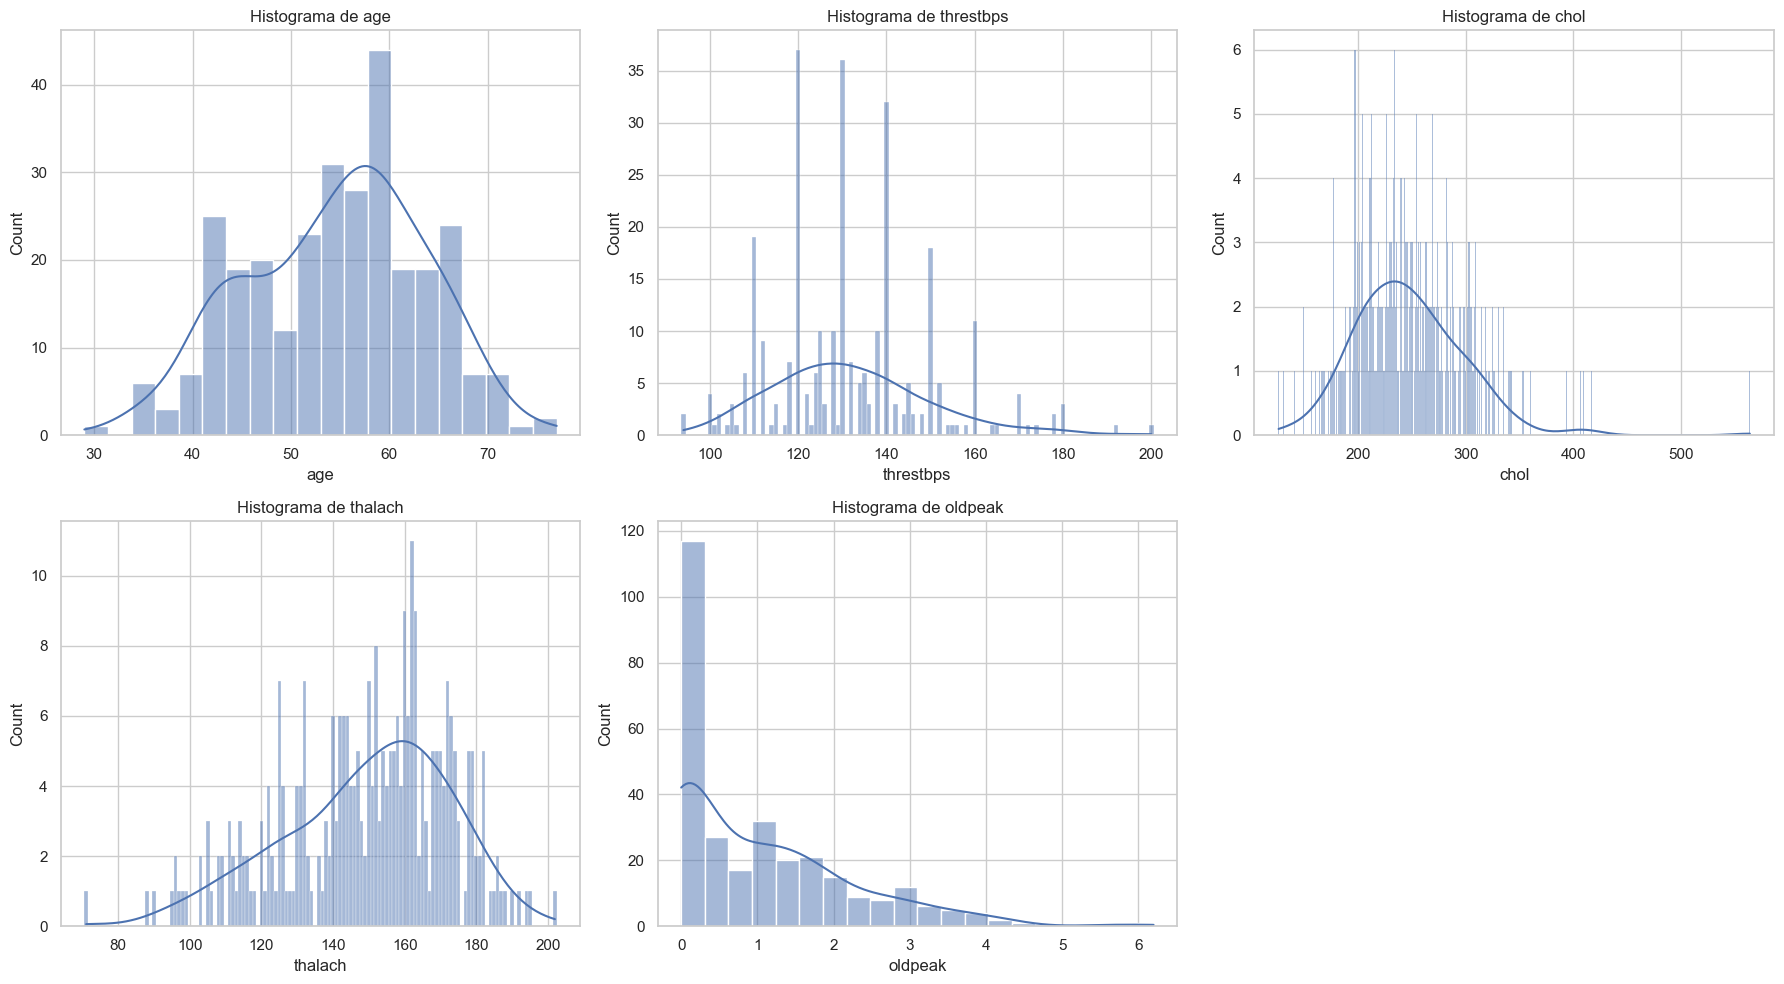

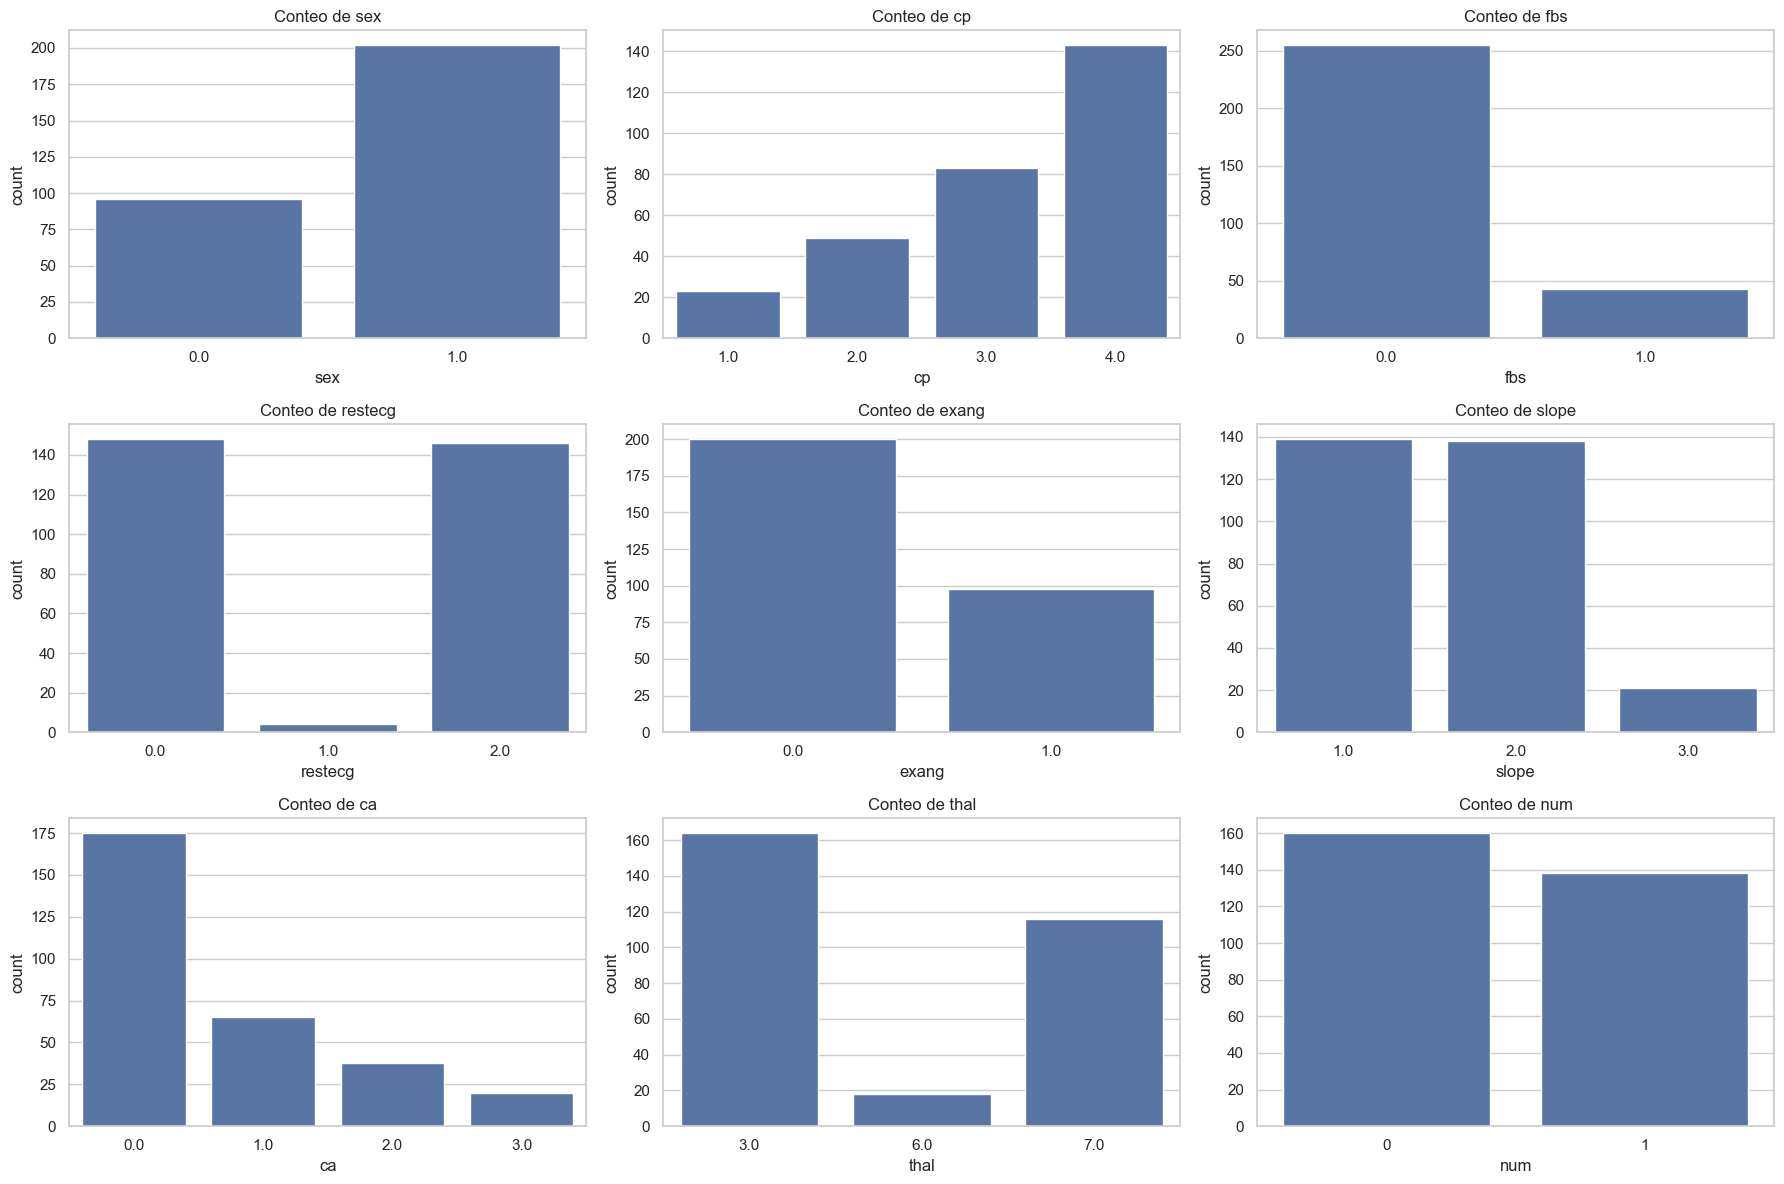

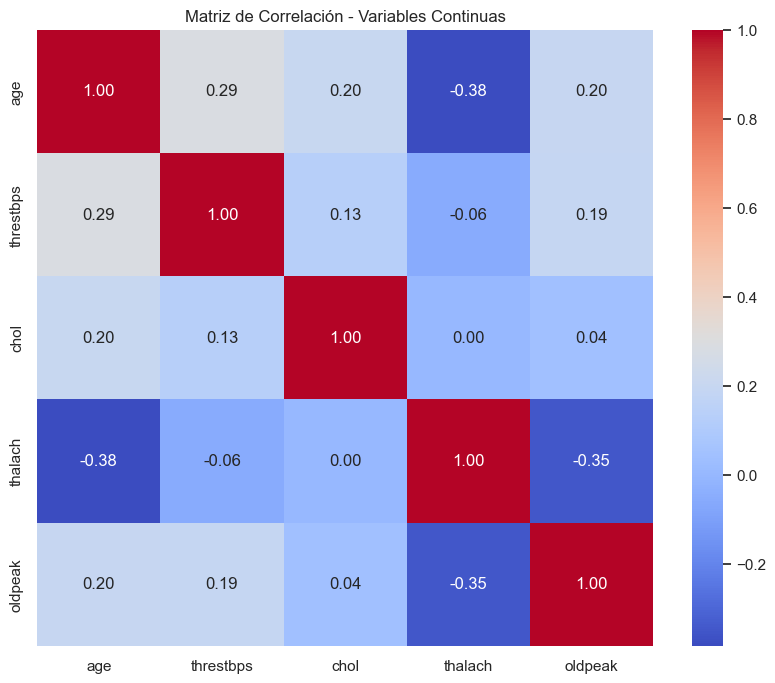

,age,threstbps,chol,thalach,oldpeak
age,1.000000,0.286736,0.203500,-0.384537,0.195776
threstbps,0.286736,1.000000,0.129842,-0.056333,0.192175
chol,0.203500,0.129842,1.000000,0.003009,0.038049
thalach,-0.384537,-0.056333,0.003009,1.000000,-0.347494
oldpeak,0.195776,0.192175,0.038049,-0.347494,1.000000


In [89]:
# Configuramos el estilo de los gráficos

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Seleccionar columnas continuas y categóricas
continuous_cols = ['age', 'threstbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']

# Limpiar datos reemplazando valores '?' por NaN en categóricas
df_clean = df.copy()
df_clean[categorical_cols] = df_clean[categorical_cols].replace('?', pd.NA)

# Convertir categóricas a numérico donde sea posible
for col in categorical_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Crear histogramas para variables continuas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(continuous_cols):
    sns.histplot(data=df_clean, x=col, kde=True, ax=axes[idx], bins=20)
    axes[idx].set_title(f'Histograma de {col}')

axes[-1].axis('off')  # último gráfico vacío si hay impares
plt.tight_layout()
plt.show()

# Crear gráficos de barra para variables categóricas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    sns.countplot(data=df_clean, x=col, ax=axes[idx])
    axes[idx].set_title(f'Conteo de {col}')

plt.tight_layout()
plt.show()

# Matriz de correlaciones para variables continuas
corr_matrix = df_clean[continuous_cols].corr()

# Heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación - Variables Continuas")
plt.show()

corr_matrix



**1. Histograma de 'age' (Edad):**
* **Forma de la distribución:** La distribución de la edad parece ser aproximadamente normal (con forma de campana), aunque ligeramente sesgada a la izquierda.
* **Pico (Moda):** El pico de la distribución se encuentra alrededor de los 55-60 años, lo que sugiere que la mayoría de los individuos en el conjunto de datos se encuentran en este rango de edad.
* **Rango:** El rango de edades va aproximadamente desde los 30 hasta los 75 años.
* **Densidad:** La curva de densidad superpuesta refuerza la observación de una distribución en forma de campana, con una densidad más alta en el rango de 50-65 años.

**2. Histograma de 'thalrestbps':**
* **Forma de la distribución:** La distribución de esta variable (probablemente presión arterial en reposo, `thalrestbps`) está sesgada a la derecha. Hay una gran concentración de valores en el lado izquierdo de la gráfica.
* **Pico (Moda):** El pico de la distribución se encuentra alrededor de los 120-130.
* **Rango:** Los valores varían aproximadamente desde los 100 hasta casi los 200.
* **Valores atípicos:** Hay algunos valores en el extremo derecho de la distribución (por encima de 180) que podrían ser considerados valores atípicos.

**3. Histograma de 'chol' (Colesterol):**
* **Forma de la distribución:** La distribución del colesterol también parece estar sesgada a la derecha.
* **Pico (Moda):** El pico se encuentra alrededor de 220-240.
* **Rango:** Los valores de colesterol van aproximadamente desde 150 hasta 500, con la mayoría de los datos concentrados entre 150 y 300.
* **Valores atípicos:** Al igual que en el histograma anterior, hay una cola larga hacia la derecha, lo que indica la presencia de valores de colesterol muy altos que podrían ser atípicos.

**4. Histograma de 'thalach' (Frecuencia cardíaca máxima alcanzada):**
* **Forma de la distribución:** La distribución de 'thalach' es aproximadamente normal, aunque con una ligera inclinación a la izquierda.
* **Pico (Moda):** El pico de la distribución se encuentra alrededor de los 150.
* **Rango:** Los valores varían aproximadamente desde los 80 hasta los 200.
* **Densidad:** La curva de densidad superpuesta muestra una forma de campana bastante simétrica alrededor del valor de 150.

**5. Histograma de 'oldpeak':**
* **Forma de la distribución:** La distribución de 'oldpeak' (probablemente depresión del segmento ST relativa al ejercicio) está muy sesgada a la derecha. La mayoría de los valores se concentran en el lado izquierdo de la gráfica, cerca del 0.
* **Pico (Moda):** El pico de la distribución está muy cerca de 0, lo que sugiere que una gran cantidad de individuos en el conjunto de datos no experimentan una depresión significativa del segmento ST durante el ejercicio.
* **Rango:** Los valores van desde 0 hasta aproximadamente 6.
* **Interpretación:** La forma de esta distribución es notablemente diferente a las demás, con una alta concentración de datos en un solo punto, lo que podría indicar una característica específica de esta variable.

## _Gráficos de barras_

**1. Conteo de 'sex':**
* **Variable:** 'sex' (género), con valores 0 y 1. Es probable que 1 represente el género masculino y 0 el femenino.
* **Análisis:** Hay una clara mayoría de individuos del género 1 (aproximadamente 200), en comparación con el género 0 (alrededor de 100). Esto indica que el conjunto de datos está desequilibrado en cuanto a la representación de género.

**2. Conteo de 'cp':**
* **Variable:** 'cp' (tipo de dolor en el pecho), con valores 1, 2, 3 y 4.
* **Análisis:** El tipo de dolor '4' es el más frecuente, con más de 140 casos. El tipo '3' y '2' son menos comunes, y el tipo '1' es el menos frecuente.

**3. Conteo de 'fbs':**
* **Variable:** 'fbs' (glucemia en ayunas > 120 mg/dl), con valores 0 y 1. Es probable que 1 signifique "sí" y 0 "no".
* **Análisis:** La gran mayoría de los individuos tienen un valor de 0 (glucemia en ayunas <= 120 mg/dl), con casi 250 casos. Solo una pequeña fracción tiene un valor de 1 (aproximadamente 40 casos).

**4. Conteo de 'restecg':**
* **Variable:** 'restecg' (resultados del electrocardiograma en reposo), con valores 0, 1 y 2.
* **Análisis:** La categoría '0' es, con diferencia, la más frecuente, con más de 140 casos. Las categorías '1' y '2' son muy poco comunes.

**5. Conteo de 'exang':**
* **Variable:** 'exang' (angina inducida por el ejercicio), con valores 0 y 1. Es probable que 1 signifique "sí" y 0 "no".
* **Análisis:** La mayoría de los individuos no experimentan angina inducida por el ejercicio (valor 0), con casi 200 casos. Alrededor de 80 individuos sí lo experimentan (valor 1).

**6. Conteo de 'slope':**
* **Variable:** 'slope' (la pendiente del segmento ST del pico del ejercicio), con valores 1, 2 y 3.
* **Análisis:** La categoría '1' y '2' son las más comunes, con aproximadamente 140 casos cada una. La categoría '3' es mucho menos frecuente, con menos de 20 casos.

**7. Conteo de 'ca':**
* **Variable:** 'ca' (número de vasos principales coloreados por fluoroscopia), con valores 0, 1, 2 y 3.
* **Análisis:** La categoría '0' es la más frecuente, con alrededor de 175 casos. A medida que el número de vasos aumenta (1, 2 y 3), la frecuencia disminuye significativamente.

**8. Conteo de 'thal':**
* **Variable:** 'thal' (defecto de talio), con valores 3, 6 y 7.
* **Análisis:** El valor '3' es el más común (aproximadamente 160 casos), seguido por el valor '7' (alrededor de 120 casos). El valor '6' es muy poco frecuente.

**9. Conteo de 'num':**
* **Variable:** 'num' (probablemente la variable objetivo que indica la presencia de una enfermedad cardíaca, con valores 0 y 1, u otras categorías).
* **Análisis:** Las categorías '0' y '1' tienen una frecuencia casi idéntica, con poco más de 140 casos cada una. Esto sugiere que la variable objetivo está bastante equilibrada en el conjunto de datos.

En resumen, estos gráficos de barras proporcionan una visión general de la composición del conjunto de datos en lo que respecta a estas variables. Revelan desequilibrios en la frecuencia de ciertas categorías, lo cual es información crucial para la selección de modelos de aprendizaje automático y para la interpretación de los resultados.

## _Matriz de Correlación_

**Análisis General de la Matriz de Correlación:**

* **Propósito:** La matriz de correlación sirve para visualizar la relación lineal entre pares de variables.
* **Escala de Colores:** La paleta de colores va de azul (correlación negativa) a rojo (correlación positiva). Un color más intenso (más oscuro) indica una correlación más fuerte (más cercana a -1 o 1), mientras que un color claro o blanco indica una correlación débil o nula (cercana a 0).
* **Diagonal Principal:** Los valores en la diagonal principal son todos 1.00, lo cual es de esperar, ya que cada variable está perfectamente correlacionada consigo misma.

**Análisis de Correlaciones Específicas:**

1.  **`age` (Edad):**
    * **Correlación con `thalach` (Frecuencia cardíaca máxima):** La correlación es de -0.38, lo que indica una relación lineal negativa moderada. Esto sugiere que, a medida que la edad aumenta, la frecuencia cardíaca máxima tiende a disminuir, lo cual es un hallazgo biológico esperado. Este es el coeficiente de correlación más fuerte en la matriz (en términos de magnitud).
    * **Correlación con `thalrestbps` (Presión arterial en reposo):** La correlación es de 0.29, una relación positiva débil a moderada. Esto sugiere que hay una ligera tendencia a que la presión arterial aumente con la edad.
    * **Correlación con `chol` (Colesterol):** La correlación es de 0.20, una relación positiva débil.
    * **Correlación con `oldpeak` (Depresión del ST):** La correlación es de 0.20, también una relación positiva débil.

2.  **`thalrestbps` (Presión arterial en reposo):**
    * **Correlación con `thalach`:** La correlación es de -0.06, lo que indica una relación lineal muy débil o inexistente.
    * **Correlación con `chol`:** La correlación es de 0.13, una relación positiva muy débil.
    * **Correlación con `oldpeak`:** La correlación es de 0.19, una relación positiva débil.

3.  **`thalach` (Frecuencia cardíaca máxima):**
    * **Correlación con `oldpeak`:** La correlación es de -0.35, una relación lineal negativa moderada. Esto sugiere que una mayor frecuencia cardíaca máxima alcanzada tiende a asociarse con un menor `oldpeak`.

4.  **`chol` (Colesterol):**
    * **Correlación con `thalach`:** La correlación es de 0.00, lo que indica que no hay una relación lineal aparente entre el colesterol y la frecuencia cardíaca máxima en este conjunto de datos.
    * **Correlación con `oldpeak`:** La correlación es de 0.04, una relación lineal casi nula.

**Conclusiones Principales:**

* **Correlaciones más fuertes:** Las correlaciones más significativas se observan entre:
    * `age` y `thalach` (-0.38).
    * `thalach` y `oldpeak` (-0.35).
* **Correlaciones débiles/nulas:**
    * `chol` muestra una correlación muy débil con casi todas las demás variables.
    * `thalrestbps` también tiene correlaciones débiles con las otras variables.
* **Implicaciones:** La matriz de correlación sugiere que la edad y la frecuencia cardíaca máxima son las variables que tienen la relación lineal más pronunciada entre sí y con el `oldpeak`. La baja correlación entre el colesterol y otras variables continuas en este conjunto de datos es un hallazgo interesante. Esta información es útil para la selección de variables en modelos predictivos o para comprender las relaciones subyacentes entre las variables del estudio.

## **Pregunta 2**

### a)

In [90]:
# Dividimos la muestra en entrenamiento y test (33%)
X = df_dummies.drop('num', axis=1)
y = df_dummies['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Entrenamos un modelo de ensamble secuencial AdaBoost con hiperparámetros por defecto
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)

# Realizamos las predicciones del modelo AdaBoost
y_pred_ada = ada_model.predict(X_test)

# Mostramos el desempeño del modelo usando métricas 
print("Desempeño del modelo AdaBoost:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_ada),2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))

Desempeño del modelo AdaBoost:
Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        48
           1       0.83      0.69      0.75        51

    accuracy                           0.77        99
   macro avg       0.78      0.77      0.77        99
weighted avg       0.78      0.77      0.77        99


Confusion Matrix:
 [[41  7]
 [16 35]]


### b)

In [91]:
#Entrenamos un modelo de ensamble secuencial Gradient Boosting con hiperparámetros por defecto
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Realizamos las predicciones del modelo Gradient Boosting
y_pred_gb = gb_model.predict(X_test)

# Mostramos el  desempeño del modelo usando métricas 
print("Desempeño del modelo Gradient Boosting:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_gb),2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Desempeño del modelo Gradient Boosting:
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.90      0.80        48
           1       0.87      0.67      0.76        51

    accuracy                           0.78        99
   macro avg       0.79      0.78      0.78        99
weighted avg       0.80      0.78      0.78        99


Confusion Matrix:
 [[43  5]
 [17 34]]


### c)

In [92]:
# Convertimos las columnas de tipo 'object' a numérico, forzando errores a NaN
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce') # Aplicar también a X_test

# Imputamos los valores NaN resultantes (por ejemplo, con la media)
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        mean_val = X_train[col].mean()
        X_train[col] = X_train[col].fillna(mean_val)
        X_test[col] = X_test[col].fillna(mean_val)

#Entrenamos un modelo de ensamble secuencial XGBoost con hiperparámetros por defecto
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Realizamos las predicciones del modelo XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Mostramos el desempeño del modelo usando métricas 
print("Desempeño del modelo XGBoost:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_xgb),2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Desempeño del modelo XGBoost:
Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.94      0.80        48
           1       0.91      0.61      0.73        51

    accuracy                           0.77        99
   macro avg       0.80      0.77      0.76        99
weighted avg       0.81      0.77      0.76        99


Confusion Matrix:
 [[45  3]
 [20 31]]


## _Diferencias Clave_:

### _Accuracy General_: Gradient Boosting tiene una ligera ventaja en la precisión general (0.78) sobre AdaBoost y XGBoost (ambos 0.77). Sin embargo, la diferencia es mínima y podría no ser estadísticamente significativa.

## Balance entre Clases:

**AdaBoost**: Muestra un buen equilibrio, aunque con un recall ligeramente mejor para la clase 0 y una precisión ligeramente mejor para la clase 1.

**Gradient Boosting**: Es el modelo más equilibrado en general, con un buen desempeño en ambas clases y la mayor precisión general. Mejora el recall de la clase 0 y la precisión de la clase 1 respecto a AdaBoost.

**XGBoost**: Muestra una clara preferencia por la clase 0 en términos de recall (identifica casi todas las instancias reales de la clase 0), pero a costa de una menor precisión para la clase 0 y un recall más bajo para la clase 1. Es decir, es muy bueno encontrando la clase 0, pero tiende a clasificar erróneamente más instancias de la clase 1 como clase 0. Por otro lado, cuando predice la clase 1, es muy fiable (alta precisión).

## _Tipos de Errores_
:
**AdaBoost y Gradient Boosting**: Tienen un número similar de falsos positivos para la clase 1 (16 y 17 respectivamente), lo que significa que confunden la clase 1 con la clase 0 en una cantidad similar de ocasiones.

**XGBoost**: Tiene el menor número de falsos negativos para la clase 0 (3), lo que es excelente si minimizar este tipo de error es crítico. Sin embargo, tiene el mayor número de falsos positivos para la clase 1 (20), lo que indica que es más propenso a clasificar incorrectamente la clase 1 como clase 0.

## **Conclusión**:

Si la precisión general es la métrica más importante y se busca un modelo equilibrado en el desempeño de ambas clases, Gradient Boosting parece ser la mejor opción.

Si es crítico identificar la mayoría de las instancias de la Clase 0 (alto recall para la Clase 0) y se puede tolerar clasificar erróneamente más instancias de la Clase 1 como Clase 0, XGBoost es superior. También es la mejor opción si la fiabilidad de las predicciones de la Clase 1 (alta precisión para la Clase 1) es clave.

AdaBoost ofrece un rendimiento sólido y equilibrado, siendo una alternativa viable si los otros modelos no cumplen con requisitos específicos o si se busca una implementación más sencilla.

La elección del mejor modelo dependerá de la importancia relativa de cada métrica para el problema específico que se está resolviendo.




## **Pregunta 3**

In [93]:
from xgboost import XGBClassifier
import numpy as np

# Usamos el mejor modelo previamente identificado: XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Definimos la grilla de hiperparámetros
param_grid = {
    'n_estimators': np.linspace(20, 200, 15, dtype=int),
    'learning_rate': np.linspace(0.004, 1.0, 40),
    'subsample': np.linspace(0.1, 1.0, 18)
}

# Búscamos con validación cruzada
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Ejecutamos la búsqueda
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo y evaluar
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_report = classification_report(y_test, y_pred_best, output_dict=True)
grid_search.best_params_, best_report


Fitting 5 folds for each of 10800 candidates, totalling 54000 fits


({'learning_rate': 0.10615384615384615, 'n_estimators': 32, 'subsample': 1.0},
 {'0': {'precision': 0.7241379310344828,
   'recall': 0.875,
   'f1-score': 0.7924528301886793,
   'support': 48.0},
  '1': {'precision': 0.8536585365853658,
   'recall': 0.6862745098039216,
   'f1-score': 0.7608695652173914,
   'support': 51.0},
  'accuracy': 0.7777777777777778,
  'macro avg': {'precision': 0.7888982338099243,
   'recall': 0.7806372549019608,
   'f1-score': 0.7766611977030353,
   'support': 99.0},
  'weighted avg': {'precision': 0.7908606672273619,
   'recall': 0.7777777777777778,
   'f1-score': 0.7761826633852884,
   'support': 99.0}})

**Los valores de los hiperparámetros que GridSearchCV** determinó que ofrecían el mejor rendimiento (el F1-score más alto en la validación cruzada) para tu modelo XGBClassifier:

_learning rate: 0.10615_: Este es el "tamaño del paso" o "tasa de aprendizaje". Un valor de aproximadamente 0.106 es un valor moderado. Indica que cada nuevo árbol en el conjunto contribuye con un 10.6% de su predicción al modelo final. Un learning_rate más bajo generalmente requiere más n_estimators pero puede llevar a un modelo más robusto y menos propenso al sobreajuste.

_n estimators: 32_: Este es el número de árboles de decisión que el modelo XGBoost construyó. El GridSearchCV encontró que 32 árboles eran suficientes para lograr el mejor rendimiento con el learning_rate dado. Es un número relativamente bajo, lo que sugiere que el modelo converge rápidamente o que un mayor número de árboles podría llevar a sobreajuste con esta configuración.

_subsample: 1.0_ Este valor indica que el 100% de las muestras de entrenamiento se utilizaron para construir cada árbol individual en el conjunto. Esto significa que no se realizó submuestreo de filas para cada árbol. Un subsample menor a 1.0 (por ejemplo, 0.8) se usa a menudo para reducir el sobreajuste al introducir aleatoriedad en el proceso de construcción del árbol. En este caso, el modelo encontró que usar todas las muestras era óptimo.

## _Informe de Clasificación (best report)_

### **Métricas por Clase**:

#### _Clase 0_:

**Precision: 0.724**
De todas las veces que el modelo predijo "Clase 0", el 72.4% de esas predicciones fueron correctas.

**Recall: 0.875**
De todas las instancias que realmente eran "Clase 0", el modelo identificó correctamente el 87.5% de ellas. Esto es un recall bastante alto, lo que significa que el modelo es bueno para no perder instancias de la Clase 0.

**F1-score: 0.792**
Es la media armónica de precisión y recall. Un buen balance para la Clase 0.

#### _Clase 1_:

**Precision: 0.854**
De todas las veces que el modelo predijo "Clase 1", el 85.4% de esas predicciones fueron correctas. Esto es una precisión muy buena, lo que significa que cuando el modelo dice que algo es Clase 1, es muy probable que lo sea.

**Recall: 0.686**
De todas las instancias que realmente eran "Clase 1", el modelo identificó correctamente el 68.6% de ellas. Este recall es más bajo que el de la Clase 0, lo que indica que el modelo tiene más dificultades para identificar todas las instancias de la Clase 1, y es más propenso a clasificarlas erróneamente como Clase 0.

**F1-score: 0.761**
Un F1-score razonable para la Clase 1, aunque ligeramente inferior al de la Clase 0.

### _Métricas Globales_:

#### **accuracy: 0.778**

El 77.8% de todas las predicciones realizadas por el modelo en el conjunto de prueba fueron correctas.
macro avg:

Precision: 0.789
Recall: 0.781
F1-score: 0.777

Calcula el promedio de las métricas (precisión, recall, F1-score) para cada clase, sin tener en cuenta el desequilibrio de clases. Es útil cuando todas las clases son igualmente importantes.
weighted avg:

Precision: 0.791
Recall: 0.778
F1-score: 0.776

Calcula el promedio de las métricas ponderado por el número de instancias de cada clase (support). Es más representativo del rendimiento general cuando las clases están desequilibradas. En este caso, como las clases están casi equilibradas (48 vs 51), los promedios macro y ponderado son muy similares.
Comparación con el Análisis Previo de XGBoost
Si comparamos este resultado del XGBoost optimizado con el "Desempeño del modelo XGBoost" que analizaste previamente:

## _XGBoost (Pre-optimización)_:

**Accuracy: 0.77**

Clase 0: Precision 0.69, Recall 0.94, F1-score 0.80
Clase 1: Precision 0.91, Recall 0.61, F1-score 0.73

## _XGBoost (Optimizado con GridSearchCV)_:

**Accuracy: 0.778**

Clase 0: Precision 0.724, Recall 0.875, F1-score 0.792
Clase 1: Precision 0.854, Recall 0.686, F1-score 0.761

###_Observaciones de la Optimización_:

Accuracy: Ha mejorado ligeramente de 0.77 a 0.778.

Clase 0:
La precisión para la Clase 0 ha mejorado significativamente (de 0.69 a 0.724). Esto significa que el modelo optimizado es más fiable cuando predice la Clase 0.

El recall para la Clase 0 ha disminuido ligeramente (de 0.94 a 0.875). Esto indica que el modelo optimizado es un poco menos exhaustivo en la identificación de todas las instancias de la Clase 0, pero sigue siendo muy bueno.

El F1-score para la Clase 0 se mantiene muy similar (0.80 vs 0.792).
Clase 1:

La precisión para la Clase 1 ha disminuido (de 0.91 a 0.854). El modelo es un poco menos fiable cuando predice la Clase 1.

El recall para la Clase 1 ha mejorado (de 0.61 a 0.686). Esto es una mejora importante, ya que el modelo ahora es capaz de identificar una mayor proporción de las instancias reales de la Clase 1.

El F1-score para la Clase 1 ha mejorado (de 0.73 a 0.761).

##_Conclusión de la Optimización_:

La optimización con GridSearchCV ha logrado un modelo XGBoost con un mejor equilibrio entre las métricas de ambas clases. Aunque el recall de la Clase 0 disminuyó ligeramente, la precisión de la Clase 0 mejoró, y lo más importante, el recall de la Clase 1 mejoró notablemente. Esto resultó en un F1-score general ligeramente mejorado para la Clase 1 y una precisión general (accuracy) marginalmente superior.

El modelo optimizado es ahora más robusto y equilibrado en su capacidad de clasificar ambas clases, lo cual es deseable en muchos escenarios donde ambas clases tienen importancia.

## **Pregunta 4**

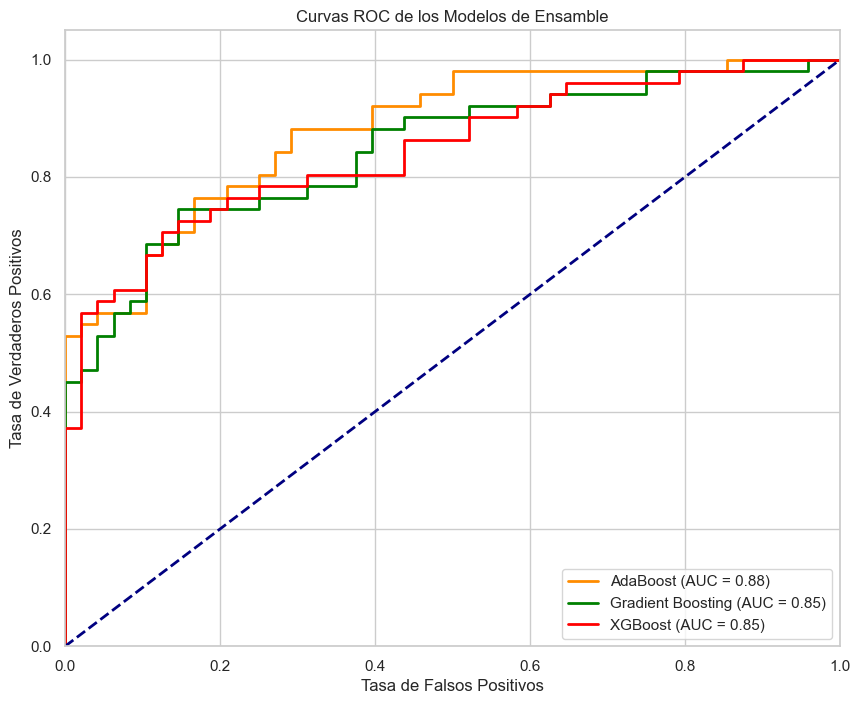


Recomendación del modelo:
Basándonos en las curvas ROC y el área bajo la curva (AUC), el modelo con el mayor AUC es generalmente el que tiene un mejor desempeño general, ya que indica una mayor capacidad para distinguir entre las clases positiva y negativa.

El modelo recomendado es: AdaBoost con un AUC de 0.88


In [94]:
# Calculamos las probabilidades de predicción para cada modelo
y_prob_ada = ada_model.predict_proba(X_test)[:, 1]
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculamos las curvas ROC y el AUC para cada modelo
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_prob_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Graficamos las curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_ada, tpr_ada, color='darkorange', lw=2, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Graficar la curva ROC del modelo de refuerzo de gradiente ajustado, si existe
if 'best_gb_model' in locals():
    y_prob_best_gb = best_gb_model.predict_proba(X_test)[:, 1]
    fpr_best_gb, tpr_best_gb, _ = roc_curve(y_test, y_prob_best_gb)
    roc_auc_best_gb = auc(fpr_best_gb, tpr_best_gb)
    plt.plot(fpr_best_gb, tpr_best_gb, color='purple', lw=2, label=f'Gradient Boosting (Tuned) (AUC = {roc_auc_best_gb:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC de los Modelos de Ensamble')
plt.legend(loc="lower right")
plt.show()

# Recomendación del modelo
print("\nRecomendación del modelo:")
print("Basándonos en las curvas ROC y el área bajo la curva (AUC), el modelo con el mayor AUC es generalmente el que tiene un mejor desempeño general, ya que indica una mayor capacidad para distinguir entre las clases positiva y negativa.")

# Determinamos el modelo con el AUC más alto
models_auc = {
    'AdaBoost': roc_auc_ada,
    'Gradient Boosting': roc_auc_gb,
    'XGBoost': roc_auc_xgb,
}

if 'best_gb_model' in locals():
     models_auc['Gradient Boosting (Tuned)'] = roc_auc_best_gb


best_model_name = max(models_auc, key=models_auc.get)
print(f"\nEl modelo recomendado es: {best_model_name} con un AUC de {models_auc[best_model_name]:.2f}")

## **1. Propósito del Gráfico:**
* Las curvas ROC son una herramienta para evaluar el rendimiento de un clasificador binario.
* El eje X representa la **Tasa de Falsos Positivos (FPR)**, que es la proporción de negativos reales que se clasificaron incorrectamente como positivos.
* El eje Y representa la **Tasa de Verdaderos Positivos (TPR)** o "recall", que es la proporción de positivos reales que se clasificaron correctamente.
* La línea diagonal punteada azul (`Tasa de Falsos Positivos = Tasa de Verdaderos Positivos`) representa el rendimiento de un clasificador aleatorio. Cualquier modelo por debajo de esta línea es peor que el azar.

## **2. Análisis de las Curvas de los Modelos:**

* **AdaBoost (Curva Naranja):**
    * **AUC (Area Under the Curve):** 0.88
    * **Análisis:** La curva de AdaBoost está consistentemente por encima de las otras dos curvas en gran parte del gráfico. Un AUC de 0.88 es un valor muy alto, lo que indica que el modelo tiene una excelente capacidad para distinguir entre las clases positiva y negativa. El modelo tiene una alta tasa de verdaderos positivos (TPR) a expensas de una tasa de falsos positivos (FPR) relativamente baja, lo que lo convierte en el modelo con mejor rendimiento de los tres mostrados.

* **Gradient Boosting (Curva Verde):**
    * **AUC:** 0.85
    * **Análisis:** La curva de Gradient Boosting está por debajo de la de AdaBoost, pero se mantiene significativamente por encima de la línea del clasificador aleatorio. Un AUC de 0.85 indica un rendimiento muy bueno, similar al de XGBoost. Sin embargo, en el rango medio del gráfico, la curva verde está ligeramente por debajo de la curva roja (XGBoost) y de la naranja (AdaBoost), lo que sugiere que podría ser ligeramente menos eficaz en ese rango de umbrales.

* **XGBoost (Curva Roja):**
    * **AUC:** 0.85
    * **Análisis:** La curva de XGBoost tiene un AUC idéntico al de Gradient Boosting (0.85), lo que sugiere que su capacidad de clasificación general es comparable. Sin embargo, su curva tiene un comportamiento ligeramente diferente. Por ejemplo, en las tasas de falsos positivos muy bajas (cerca de 0.0), el modelo XGBoost tiene un TPR más bajo que los otros modelos, lo que indica que no es tan bueno para identificar a los positivos reales con una alta certeza. A medida que la FPR aumenta, su rendimiento mejora y se vuelve comparable al de Gradient Boosting.

## **3. Conclusiones Principales:**

* **Clasificador Superior:** De los tres modelos presentados, **AdaBoost es el que tiene el mejor rendimiento**, con el área bajo la curva (AUC) más alta de 0.88. Esto indica que tiene la mayor capacidad de discriminar entre las clases.
* **Rendimiento Comparable:** Gradient Boosting y XGBoost tienen un rendimiento global similar, con un AUC de 0.85. La elección entre estos dos podría depender de otros factores, como la velocidad de entrenamiento, la capacidad de ajuste a los datos específicos o la interpretabilidad.
* **Validez de los Modelos:** Todos los modelos de ensamble mostrados tienen un AUC significativamente mayor que 0.5 (la línea del clasificador aleatorio), lo que confirma que son modelos válidos y predictivos.
* **Implicaciones:** Para este problema de clasificación, el modelo AdaBoost sería la elección preferida si el objetivo principal es maximizar la capacidad de predicción. Sin embargo, los otros dos modelos también ofrecen un rendimiento muy sólido.

## **Pregunta 5**

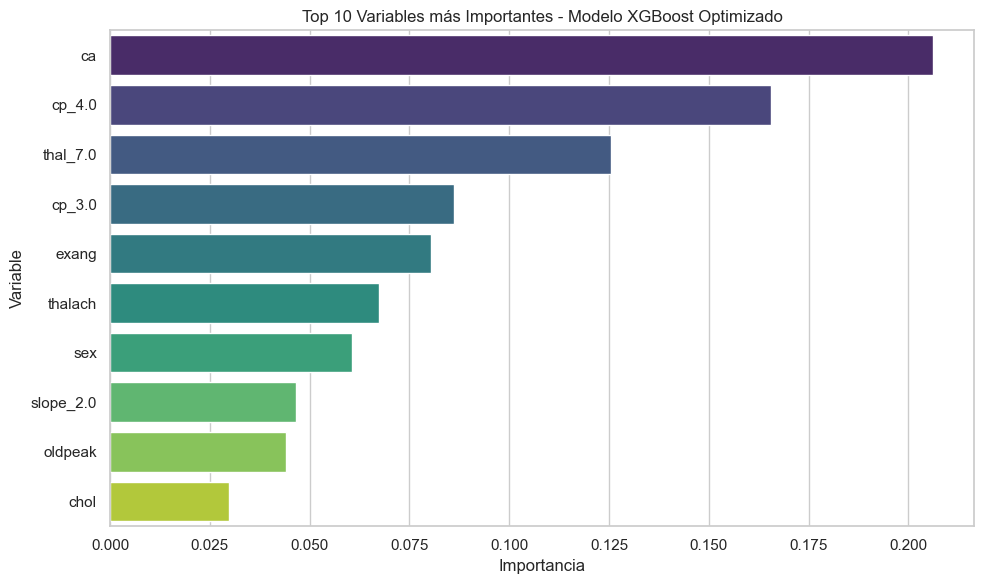

In [95]:
# Importancia de las características a partir del mejor modelo
importances = best_model.feature_importances_

# Asociamos la importancia con los nombres de las columnas
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Mostramos el top 10 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Variables más Importantes - Modelo XGBoost Optimizado')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


* Mostramos qué variables tuvieron el mayor impacto en las predicciones del clasificador XGBoost.
* La "Importancia" se mide en el eje X y representa la contribución relativa de cada variable para el modelo. A menudo se calcula basándose en métricas como el número de veces que se utiliza una variable para dividir un nodo en los árboles del modelo.
* El eje Y muestra las 10 variables más importantes, ordenadas de mayor a menor importancia.

**Análisis**

* **1. `ca`:**
    * **Importancia:** Es, con diferencia, la variable más importante, con un valor de importancia superior a 0.20.
    * **Significado:** `ca` representa el número de vasos principales coloreados por fluoroscopia (0-3). Su alta importancia sugiere que el número de vasos afectados es un predictor extremadamente fuerte de la enfermedad que el modelo está tratando de clasificar.

* **2. `cp_4.0`:**
    * **Importancia:** Esta variable se encuentra en el segundo lugar, con un valor de importancia cercano a 0.18.
    * **Significado:** `cp` es el tipo de dolor en el pecho. `cp_4.0` es una de las categorías (posiblemente dolor atípico o asintomático). La alta importancia de esta variable indica que tener este tipo de dolor en el pecho es un factor clave en las predicciones del modelo. Esto puede ser el resultado de la codificación one-hot de la variable original `cp`.

* **3. `thal_7.0`:**
    * **Importancia:** Con un valor de importancia alrededor de 0.14, ocupa el tercer lugar.
    * **Significado:** `thal` se refiere a los resultados de la prueba de estrés con talio. `thal_7.0` es una de las categorías (posiblemente un defecto reversible o fijo). La importancia de esta variable sugiere que esta categoría específica del defecto de talio es un predictor muy relevante para el modelo. Al igual que con `cp`, esto también es probable que sea una variable codificada.

* **4. `cp_3.0`:**
    * **Importancia:** Con una importancia cercana a 0.08, se ubica en el cuarto lugar.
    * **Significado:** Similar a `cp_4.0`, esta es otra categoría del tipo de dolor en el pecho. Su relevancia sugiere que las diferentes categorías de `cp` tienen un peso significativo en la predicción.

* **5. `exang`:**
    * **Importancia:** Con un valor de importancia similar a `cp_3.0`, se encuentra en el quinto lugar.
    * **Significado:** `exang` indica si se experimenta angina (dolor en el pecho) inducida por el ejercicio. Su importancia confirma que la presencia o ausencia de este síntoma es un factor crucial para el modelo.

* **6. `thalach`:**
    * **Importancia:** Se encuentra en el sexto lugar, con una importancia de aproximadamente 0.06.
    * **Significado:** `thalach` es la frecuencia cardíaca máxima alcanzada. Su presencia entre las variables más importantes es coherente con el conocimiento médico, ya que la capacidad del corazón para acelerar durante el ejercicio es un indicador de salud.

* **7. `sex`:**
    * **Importancia:** Con un valor de importancia cercano a 0.06, se ubica en el séptimo lugar.
    * **Significado:** El género del individuo (`sex`) es un factor relevante, lo que sugiere que hay diferencias de riesgo entre hombres y mujeres que el modelo está capturando.

* **8. `slope_2.0`:**
    * **Importancia:** Esta categoría de la pendiente del segmento ST tiene una importancia de aproximadamente 0.05.
    * **Significado:** Similar a `cp` y `thal`, esta variable codificada demuestra que una pendiente específica del segmento ST durante el ejercicio es un factor predictivo relevante.

* **9. `oldpeak`:**
    * **Importancia:** Con una importancia de alrededor de 0.045, se ubica en el noveno lugar.
    * **Significado:** `oldpeak` mide la depresión del segmento ST. Su importancia es coherente con la de `slope`, ya que ambas están relacionadas con los resultados de la prueba de esfuerzo.

* **10. `chol`:**
    * **Importancia:** Con un valor de importancia inferior a 0.03, es la décima variable en la lista.
    * **Significado:** Aunque el nivel de colesterol es un factor de riesgo cardiovascular conocido, en este modelo y conjunto de datos, su importancia es considerablemente menor que la de otras variables. Esto podría indicar que la información que aporta el colesterol ya está parcialmente capturada por otras variables o que, en este contexto particular, su poder predictivo es más limitado en comparación con otras características clínicas.

**Conclusión General:**
El análisis de la importancia de las variables confirma que los predictores más fuertes del modelo están directamente relacionados con los hallazgos de pruebas clínicas y diagnósticas (`ca`, `cp`, `thal`, `exang`). Los factores demográficos (`sex`) y los resultados de las pruebas de esfuerzo (`thalach`, `oldpeak`, `slope`) también son relevantes, pero con menor peso. El colesterol (`chol`), a pesar de ser un factor de riesgo conocido, tiene la menor importancia en este top 10, lo que es una observación interesante sobre la especificidad de este modelo y conjunto de datos.